<a href="https://colab.research.google.com/github/gisa-ceinfo-sms-sp/isacapitalsp/blob/main/ISA_CAPITAL_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

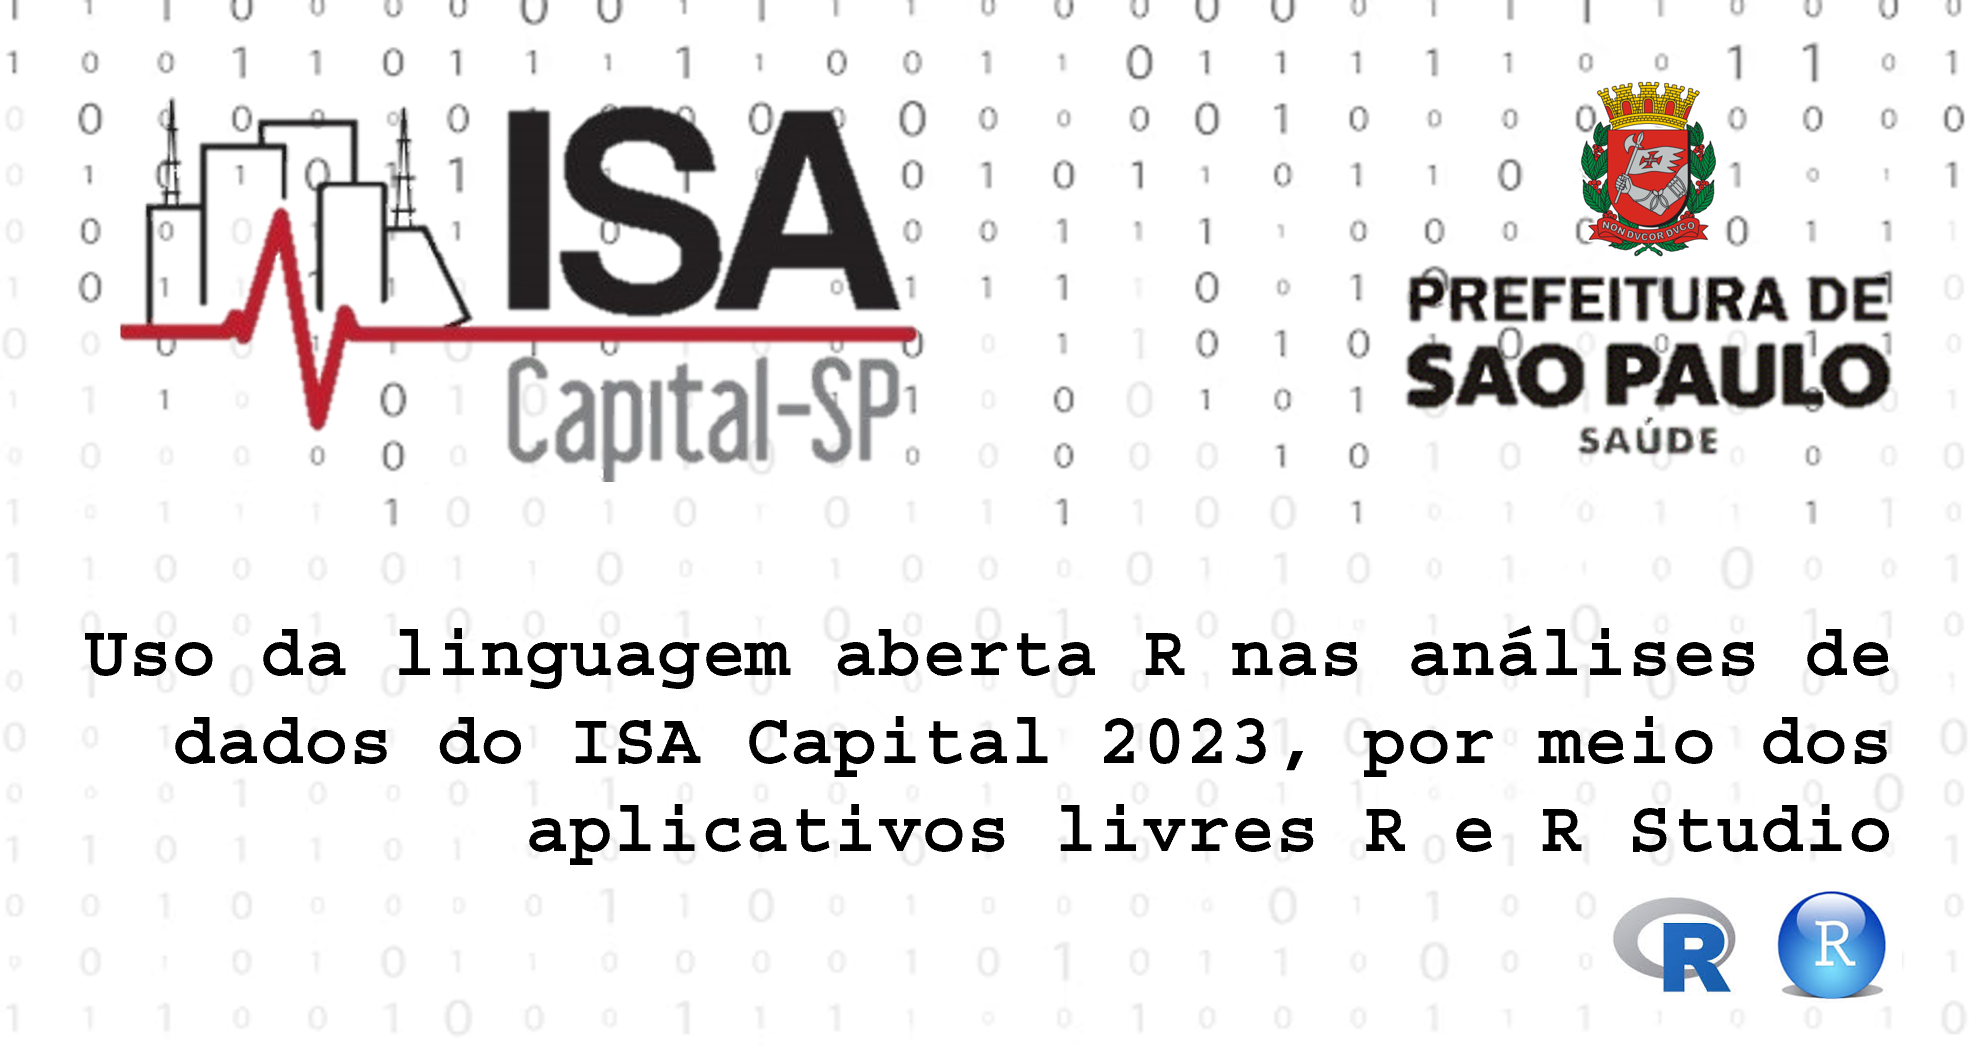

# **CODIGO-BASE - ISA CAPITAL 2023 - SMS-SP (V.12/06/2025)**

---

**ELABORAÇÃO:** Secretaria Municipal da Saúde de São Paulo (SMS-SP)
José Olimpio Moura de Albuquerque (NADEpi/CIEVS/DEVE/COVISA/SEABEVS), Marcelo Antunes Failla (GISA/CEInfo/CIS/SERMAP)

---

**INSTRUÇÕES PARA RODAR O SCRIPT VIA GOOGLE COLAB**
1. Faça upload do arquivo **"ISACapital17042025TreinamentoComPesosExcluiVar.SAV"** para a pasta **"/content"** e certifique-se da conclusão do upload
2. Selecione todas as linhas e clique no "botão de play" ou em "ambiente de execução>executar seleção"
3. Os arquivos de saída salvos na pasta "/content"


---

**INSTRUÇÕES PARA RODAR O SCRIPT EM SUA MÁQUINA (PROCESSAMENTO LOCAL)**

*VERSÕES UTILIZADAS PARA PROCESSAMENTO: [R-4.5.0 for Windows](https://cran.r-project.org/bin/windows/base/R-4.5.0-win.exe) e [RStudio 2025.05.0 Build 496](https://download1.rstudio.org/electron/windows/RStudio-2025.05.1-513.exe)*

1. CRIE A PASTA "C:/ISA_CAPITAL"
2. Insira o arquivo "ISACapital17042025TreinamentoComPesosExcluiVar.SAV"
3. Copie este código para o seu R Studio em sua máquina, em um novo script ou no script já em uso por versões anteriores
4. Selecione todas as linhas e clique em "run"
5. Os arquivos de saída serão salvos na mesma pasta onde está a base "c:/ISA_Capital"


---

**Saiba mais sobre o Inquérito de Saúde no Município de São Paulo**

[Site da SMS-SP / PrefSP](https://prefeitura.sp.gov.br/web/saude/epidemiologia_e_informacao/isacapitalsp) e [Site da FSP / USP](https://www.fsp.usp.br/isa-capital/)*

In [ ]:


install.packages("haven")   # Para ler arquivos .sav
install.packages("survey")  # O pacote survey realiza a análise de amostras complexas
install.packages("srvyr")  # O pacote srvyr baseado no 'survey' realiza a análise no padrão do tidyverse
install.packages("labelled")
install.packages("flextable")
install.packages("officer")
install.packages("stats")
install.packages("glue")


library(tidyverse)
library(haven)
library(survey)
library(srvyr)
library(purrr)
library(tibble)
library(labelled)
library(flextable)
library(officer)
library(glue)
#library(janitor)
library(stats)


#define a pasta onde estão os arquivos
#setwd("c:/ISA_CAPITAL")

#ler o arquivo de dados do SPSS
dados <- read_sav("/content/ISACapital17042025TreinamentoComPesosExcluiVar.SAV")



## exportar para .dat
#longos <- names(dados)[nchar(names(dados)) > 32]
#names(dados) <- abbreviate(names(dados), minlength = 8, strict = TRUE)
#write_dta(dados,"ISACapital17042025TreinamentoComPesosExcluiVar.dta", version = 13)
#########################################

#cria a coluna faixa etaria e exclui os registros com o peso final em branco
dados2 <- dados %>%
  mutate(
    FX_ETARIA = cut(
      IDADECALC,
      breaks = c(10, 20, 30, 40, 50, 60, 70, 80, 90, Inf),
      right = FALSE,
      labels = c(
        "10-19", "20-29", "30-39", "40-49",
        "50-59", "60-69", "70-79", "80-89", "90 ou +"
      )
    )
  ) %>%
  filter(!is.na(pesofinal))




## gera um data frame com os nomes das variáveis
# Função segura para extrair 1º label (ou NA se não houver)
extrair_label <- function(x) {
  lbl <- attr(x, "label")
  if (is.null(lbl)) return(NA_character_)
  if (length(lbl) > 1) return(paste(lbl, collapse = " | "))
  return(as.character(lbl))
}

# Função segura para extrair val_labels
extrair_val_labels <- function(x) {
  vl <- val_labels(x)
  if (is.null(vl)) return(NA_character_)
  paste(names(vl), "=", vl, collapse = "; ")
}

# Aplica ao banco
variaveis_info <- tibble(
  nome_variavel   = names(dados),
  label_variavel  = map_chr(dados, extrair_label),
  categorias      = map_chr(dados, extrair_val_labels),
  tipo_variavel   = map_chr(dados, ~ class(.)[1])
)


### Gera o arquivo CSV com as informações das variáveis
write.csv2(variaveis_info, "dicionario_variaveis.csv", row.names = FALSE, fileEncoding = "Windows-1252")


################################################################

# Define o desenho do estudo
des <- svydesign(
  id = ~cod_setor,
  strata = ~cod_coord,
  weights = ~pesofinal,
  data = dados2,
  nest = TRUE
)

# Cria versão srvyr do design
des_srvyr <- as_survey_design(des)

###################################################################################
########################## FAZ A TABULAÇÃO DAS VARIÁVEIS ##########################

# Exemplo com sexo
# o comando 'mutate(sexo = as_factor(b08_sexo))' recupera a variável b08_sexo do banco de dados
# e transforma em fator com a descrição do código que já está no arquivo .sav


freq_sexo <- des_srvyr %>%
  filter(!is.na(b07_sexo_geral)) %>%
  mutate(sexo = as_factor(b07_sexo_geral)) %>%
  group_by(sexo) %>%
  summarise(prop = survey_mean(vartype = c("ci", "se"), proportion = TRUE)) %>%
  mutate(
    Proporção = prop * 100,
    IC_inf = prop_low * 100,
    IC_sup = prop_upp * 100,
    Erro_Padrão = prop_se * 100,
    CV = (prop_se / prop) * 100
  ) %>%
  select(sexo, Proporção, IC_inf, IC_sup, Erro_Padrão, CV)


freq_morbidade2semanas <- des_srvyr %>%
  filter(!is.na(c101_morbidade2semanas)) %>%
  mutate(morbidade2semanas = as_factor(c101_morbidade2semanas)) %>%
  group_by(morbidade2semanas) %>%
  summarise(prop = survey_mean(vartype = c("ci", "se"), proportion = TRUE)) %>%
  mutate(
    Proporção = prop,
    IC_inf = prop_low,
    IC_sup = prop_upp,
    Erro_Padrão = prop_se * 100,
    CV = (prop_se / prop) * 100
  ) %>%
  select(morbidade2semanas, Proporção, IC_inf, IC_sup, Erro_Padrão, CV)


freq_hipertensao <- des_srvyr %>%
  filter(!is.na(c201a_hipertensao)) %>%
  mutate(hipertensao = as_factor(c201a_hipertensao)) %>%
  group_by(hipertensao) %>%
  summarise(prop = survey_mean(vartype = "ci", proportion = TRUE)) %>%
  mutate(across(c(prop, prop_low, prop_upp), ~ . * 100)) %>%
  rename(Proporção = prop, IC_inf = prop_low, IC_sup = prop_upp)

freq_hipertensao <- des_srvyr %>%
  filter(!is.na(c201a_hipertensao)) %>%
  mutate(hipertensao = as_factor(c201a_hipertensao)) %>%
  group_by(hipertensao) %>%
  summarise(prop = survey_mean(vartype = c("ci", "se"), proportion = TRUE)) %>%
  mutate(
    Proporção = prop * 100,
    IC_inf = prop_low * 100,
    IC_sup = prop_upp * 100,
    Erro_Padrão = prop_se * 100,
    CV = (prop_se / prop) * 100
  ) %>%
  select(hipertensao, Proporção, IC_inf, IC_sup, Erro_Padrão, CV)


freq_diabetes <- des_srvyr %>%
  filter(!is.na(c202a_diabetes)) %>%
  mutate(diabetes = as_factor(c202a_diabetes)) %>%
  group_by(diabetes) %>%
  summarise(prop = survey_mean(vartype = c("ci", "se"), proportion = TRUE)) %>%
  mutate(
    Proporção = prop * 100,
    IC_inf = prop_low * 100,
    IC_sup = prop_upp * 100,
    Erro_Padrão = prop_se * 100,
    CV = (prop_se / prop) * 100
  ) %>%
  select(diabetes, Proporção, IC_inf, IC_sup, Erro_Padrão, CV)


freq_infarto <- des_srvyr %>%
  filter(!is.na(c203a_infarto)) %>%
  mutate(infarto = as_factor(c203a_infarto)) %>%
  group_by(infarto) %>%
  summarise(prop = survey_mean(vartype = c("ci", "se"), proportion = TRUE)) %>%
  mutate(
    Proporção = prop * 100,
    IC_inf = prop_low * 100,
    IC_sup = prop_upp * 100,
    Erro_Padrão = prop_se * 100,
    CV = (prop_se / prop) * 100
  ) %>%
  select(infarto, Proporção, IC_inf, IC_sup, Erro_Padrão, CV)


freq_avc <- des_srvyr %>%
  filter(!is.na(c205a_avc)) %>%
  mutate(avc = as_factor(c205a_avc)) %>%
  group_by(avc) %>%
  summarise(prop = survey_mean(vartype = c("ci", "se"), proportion = TRUE)) %>%
  mutate(
    Proporção = prop * 100,
    IC_inf = prop_low * 100,
    IC_sup = prop_upp * 100,
    Erro_Padrão = prop_se * 100,
    CV = (prop_se / prop) * 100
  ) %>%
  select(avc, Proporção, IC_inf, IC_sup, Erro_Padrão, CV)


freq_cancer <- des_srvyr %>%
  filter(!is.na(c206a_cancer)) %>%
  mutate(cancer = as_factor(c206a_cancer)) %>%
  group_by(cancer) %>%
  summarise(prop = survey_mean(vartype = c("ci", "se"), proportion = TRUE)) %>%
  mutate(
    Proporção = prop * 100,
    IC_inf = prop_low * 100,
    IC_sup = prop_upp * 100,
    Erro_Padrão = prop_se * 100,
    CV = (prop_se / prop) * 100
  ) %>%
  select(cancer, Proporção, IC_inf, IC_sup, Erro_Padrão, CV)



freq_fx_etaria <- des_srvyr %>%
  filter(!is.na(FX_ETARIA)) %>%
  mutate(hipertensao = as_factor(FX_ETARIA)) %>%
  group_by(FX_ETARIA) %>%
  summarise(prop = survey_mean(vartype = c("ci", "se"), proportion = TRUE)) %>%
  mutate(
    Proporção = prop * 100,
    IC_inf = prop_low * 100,
    IC_sup = prop_upp * 100,
    Erro_Padrão = prop_se * 100,
    CV = (prop_se / prop) * 100
  ) %>%
  select(FX_ETARIA, Proporção, IC_inf, IC_sup, Erro_Padrão, CV)



#### GERAR DOCUMENTO COM AS TABELAS DE FREQUÊNCIA



# 🧩 Função robusta para gerar flextable
formatar_tabela <- function(df, titulo) {
  if (!is.data.frame(df) || nrow(df) == 0) {
    warning(paste("Tabela inválida ou vazia:", titulo))
    return(flextable(data.frame(Mensagem = "Tabela não disponível")))
  }
  df <- as.data.frame(df)  # garante compatibilidade
  flextable(df) %>%
    set_caption(caption = titulo) %>%
    autofit() %>%
    set_table_properties(width = 0.66, layout = "autofit")  # ⇐ Reduz largura para 66%
}

# 📄 Cria o documento Word
doc <- read_docx() %>%
  body_add_par("Tabelas de Frequência do Inquérito de Saúde", style = "heading 1") %>%
  body_add_flextable(formatar_tabela(freq_sexo, "Tabela 1 - Sexo")) %>%
  body_add_par("", style = "Normal") %>%
  body_add_flextable(formatar_tabela(freq_morbidade2semanas, "Tabela 2 - Morbidade nas Últimas 2 Semanas")) %>%
  body_add_par("", style = "Normal") %>%
  body_add_flextable(formatar_tabela(freq_hipertensao, "Tabela 3 - Hipertensão")) %>%
  body_add_par("", style = "Normal") %>%
  body_add_flextable(formatar_tabela(freq_diabetes, "Tabela 4 - Diabetes")) %>%
  body_add_par("", style = "Normal") %>%
  body_add_flextable(formatar_tabela(freq_infarto, "Tabela 5 - Infarto")) %>%
  body_add_par("", style = "Normal") %>%
  body_add_flextable(formatar_tabela(freq_avc, "Tabela 6 - AVC")) %>%
  body_add_par("", style = "Normal") %>%
  body_add_flextable(formatar_tabela(freq_cancer, "Tabela 7 - Câncer")) %>%
  body_add_par("", style = "Normal") %>%
  body_add_flextable(formatar_tabela(freq_fx_etaria, "Tabela 8 - Frequência por Faixa Etária"))

# 💾 Salva o documento
print(doc, target = "frequencias_ISA_Capital_script_v20250612.docx")


#########################################################################################
################## TABELAS CRUZADAS + teste do qui-quadrado #############################
#########################################################################################

######### Tabelas cruzadas +  o teste do qui-quadrado    ###

# Cria tabela cruzada de sexo x morbidade 2 semanas
tab_cross_sexo_morbidade2semanas <- des_srvyr %>%
  filter(!is.na(b07_sexo_geral), !is.na(c101_morbidade2semanas)) %>%
  mutate(
    sexo = as_factor(b07_sexo_geral),
    morbidade2semanas = as_factor(c101_morbidade2semanas)
  ) %>%
  group_by(sexo, morbidade2semanas) %>%
  summarise(
    prop = survey_mean(proportion = TRUE, vartype = "ci"),
    .groups = "drop"
  ) %>%
  mutate(across(c(prop, prop_low, prop_upp), ~ . * 100)) %>%
  rename(
    Proporção = prop,
    IC_inf = prop_low,
    IC_sup = prop_upp
  )

# Formatar tabela no padrão do STATA
tab_cruzada_formatada_sexo_morbidade2semanas <- tab_cross_sexo_morbidade2semanas %>%
  mutate(
    categoria = glue("{round(Proporção, 1)}% [{round(IC_inf, 1)}–{round(IC_sup, 1)}]")
  ) %>%
  select(sexo, morbidade2semanas, categoria) %>%
  pivot_wider(
    names_from = morbidade2semanas,
    values_from = categoria
  )

# Calcular o teste do qui-quadrado para as tabelas cruzadas
# Criar flextables com legenda

ftx1 <- flextable(tab_cruzada_formatada_sexo_morbidade2semanas) %>%
  set_caption("Tabela 1. Sexo x Morbidade nas últimas 2 semanas") %>%
  autofit()

# Aplicando o teste de qui-quadrado ajustado para amostragem complexa
resultado_chi <- svychisq(~b07_sexo_geral + c101_morbidade2semanas, design = des_srvyr)

# Extrair estatística F, gl e p-valor
estat_f <- round(resultado_chi$statistic, 2)
ndf <- round(resultado_chi$parameter[[1]], 2)
ddf <- round(resultado_chi$parameter[[2]], 2)
pval <- format.pval(resultado_chi$p.value, digits = 3, eps = 0.001)

# Criar texto explicativo
texto_chi <- glue("Teste de qui-quadrado com ajuste de Rao & Scott: F = {estat_f}, gl1 = {ndf}, gl2 = {ddf}, p-valor = {pval}.")

# Criar flextable
ftx1 <- flextable(tab_cruzada_formatada_sexo_morbidade2semanas) %>%
  set_caption("Tabela 1. Proporção de morbidade nas duas semanas anteriores, segundo sexo") %>%
  autofit()

# Criar documento Word
doc2 <- read_docx() %>%
  body_add_par("Tabelas Cruzadas do ISA Capital", style = "heading 1") %>%
  body_add_flextable(ftx1) %>%
  body_add_par("", style = "Normal") %>%
  body_add_par("Resultado do teste do qui-quadrado:", style = "heading 2") %>%
  body_add_par(texto_chi, style = "Normal")

rm(resultado_chi,estat_f, ndf, ddf, pval, texto_chi)

################
# Cria tabela cruzada de hipertensão x faixa etaria
tab_cross_hipertensao_faixa_etaria <- des_srvyr %>%
  filter(!is.na(FX_ETARIA)) %>%
  filter(!is.na(c201a_hipertensao)) %>%
  mutate(
    hipertensao = as_factor(c201a_hipertensao)
  ) %>%
  group_by(FX_ETARIA, hipertensao) %>%
  summarise(
    prop = survey_mean(proportion = TRUE, vartype = "ci"),
    .groups = "drop"
  ) %>%
  mutate(across(c(prop, prop_low, prop_upp), ~ . * 100)) %>%
  rename(
    Proporção = prop,
    IC_inf = prop_low,
    IC_sup = prop_upp
  )

# Formatar tabela no padrão do STATA
tab_cruzada_formatada_hipertensao_faixa_etaria <- tab_cross_hipertensao_faixa_etaria %>%
  mutate(
    categoria = glue("{round(Proporção, 1)}% [{round(IC_inf, 1)}–{round(IC_sup, 1)}]")
  ) %>%
  select(hipertensao, FX_ETARIA, categoria) %>%
  pivot_wider(
    names_from = hipertensao,
    values_from = categoria
  )

# Calcular o teste do qui-quadrado para as tabelas cruzadas

resultado_chi <- svychisq(~c201a_hipertensao + FX_ETARIA, design = des_srvyr)

# Extrair estatística F, gl e p-valor
estat_f <- round(resultado_chi$statistic, 2)
ndf <- round(resultado_chi$parameter[[1]], 2)
ddf <- round(resultado_chi$parameter[[2]], 2)
pval <- format.pval(resultado_chi$p.value, digits = 3, eps = 0.001)

# Criar texto explicativo
texto_chi <- glue("Teste de qui-quadrado com ajuste de Rao & Scott: F = {estat_f}, gl1 = {ndf}, gl2 = {ddf}, p-valor = {pval}.")

# Criar flextable
ftx2 <- flextable(tab_cruzada_formatada_hipertensao_faixa_etaria) %>%
  set_caption("Tabela 2. Proporção da prevalência da hipertensão por faixa etária") %>%
  autofit()

# Criar documento Word
doc2 <- doc2 %>%
  body_add_flextable(ftx2) %>%
  body_add_par("", style = "Normal") %>%
  body_add_par("Resultado do teste do qui-quadrado:", style = "heading 2") %>%
  body_add_par(texto_chi, style = "Normal")

rm(resultado_chi,estat_f, ndf, ddf, pval, texto_chi)

# Cria tabela cruzada de CRS x morbidade 2 semanas
tab_cross_CRS_morbidade2semanas <- des_srvyr %>%
  filter(!is.na(cod_coord)) %>%
  filter(!is.na(c101_morbidade2semanas)) %>%
  mutate(
    CRS = as_factor(cod_coord),
    morbidade2semanas = as_factor(c101_morbidade2semanas)
  ) %>%
  group_by(CRS, morbidade2semanas) %>%
  summarise(
    prop = survey_mean(proportion = TRUE, vartype = "ci"),
    .groups = "drop"
  ) %>%
  mutate(across(c(prop, prop_low, prop_upp), ~ . * 100)) %>%
  rename(
    Proporção = prop,
    IC_inf = prop_low,
    IC_sup = prop_upp
  )


# Formatar tabela no padrão do STATA
tab_cruzada_formatada_CRS_morbidade2semanas <- tab_cross_CRS_morbidade2semanas %>%
  mutate(
    categoria = glue("{round(Proporção, 1)}% [{round(IC_inf, 1)}–{round(IC_sup, 1)}]")
  ) %>%
  select(CRS, morbidade2semanas, categoria) %>%
  pivot_wider(
    names_from = morbidade2semanas,
    values_from = categoria
  )

# Calcular o teste do qui-quadrado para as tabelas cruzadas

resultado_chi <- svychisq(~cod_coord + c101_morbidade2semanas, design = des_srvyr)

# Extrair estatística F, gl e p-valor
estat_f <- round(resultado_chi$statistic, 2)
ndf <- round(resultado_chi$parameter[[1]], 2)
ddf <- round(resultado_chi$parameter[[2]], 2)
pval <- format.pval(resultado_chi$p.value, digits = 3, eps = 0.001)

# Criar texto explicativo
texto_chi <- glue("Teste de qui-quadrado com ajuste de Rao & Scott: F = {estat_f}, gl1 = {ndf}, gl2 = {ddf}, p-valor = {pval}.")

# Criar flextable
ftx3 <- flextable(tab_cruzada_formatada_CRS_morbidade2semanas) %>%
  set_caption("Tabela 3. Proporção de morbidade nas 2 últimas semanas por CRS") %>%
  autofit()

# Criar documento Word
doc2 <- doc2 %>%
  body_add_flextable(ftx3) %>%
  body_add_par("", style = "Normal") %>%
  body_add_par("Resultado do teste do qui-quadrado:", style = "heading 2") %>%
  body_add_par(texto_chi, style = "Normal")

rm(resultado_chi,estat_f, ndf, ddf, pval, texto_chi)


# Salvar documento
print(doc2, target = "tabelas_cruzadas_ISA_Capital_script_v20250612.docx")








